- 나눔글꼴 설치 및 적용
    - 설치 후 런타임 재시작 필요

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,765 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120899 files and dire

- 구글 드라이브 연동

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- 서드파티 모듈 설치

In [2]:
!pip install konlpy
!pip install mecab-python
!apt-get install -y openjdk-8-jdk
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 32.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 6.1 MB/s eta 0:00:00
  Created wheel for mecab-python: filename=mecab_python-1.0.0-py3-none-any.whl size=1232 sha256=9af55266e6392a02a355393eed2625e1200168fe8e168227db7aea12694ee2f1
  Stored in directory: /root/.cache/pip/wheels/ec/41/c8/ce8fb469be2547ce596c4000613806505dc54c296aae45da71
Successfully built mecab-python
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java libatk-wrapper-java-jni libfontenc1
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libice-dev librsvg2-common
  libsm-dev libxkbfile1 libxt-dev libxtst6 libxxf86dga1 openjdk-8-jdk-h

# [1] 모듈 로드

In [3]:
# os
import os
import sys
import re
import warnings
import random

# 분석
import pandas as pd
import numpy as np


# 시각화
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# ML
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.preprocessing import LabelEncoder, MinMaxScaler



# Text
from konlpy.tag import Mecab
from konlpy.tag import Kkma
from konlpy.utils import pprint
from sklearn.feature_extraction.text import TfidfVectorizer


warnings.filterwarnings('ignore')
%matplotlib inline

- 시드 고정

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(22) # Seed 고정

# [2] 데이터 로드

- bank_info_df : 은행 기초재무정보주요경영지표
- dp_df : 은행/저축은행 예금상품 전체

In [5]:
bank_info_df = pd.read_csv('/content/drive/MyDrive/ASAC_최종프로젝트/data/금융감독원데이터/경영지표/bank_grade.csv', encoding = 'cp949')
dp_df = pd.read_csv('/content/drive/MyDrive/ASAC/최종프로젝트_우리만/이한석/data/deposit_all.csv', encoding = 'utf-8')
dp6_df = pd.read_csv('/content/drive/MyDrive/ASAC_최종프로젝트/data/금융감독원데이터/상품데이터_크롤링/예금/deposit_6.csv', encoding = 'utf-8', index_col='Unnamed: 0')
dp12_df = pd.read_csv('/content/drive/MyDrive/ASAC_최종프로젝트/data/금융감독원데이터/상품데이터_크롤링/예금/deposit_12.csv', encoding = 'utf-8')
dp24_df = pd.read_csv('/content/drive/MyDrive/ASAC_최종프로젝트/data/금융감독원데이터/상품데이터_크롤링/예금/deposit_24.csv', encoding = 'utf-8')
dp36_df = pd.read_csv('/content/drive/MyDrive/ASAC_최종프로젝트/data/금융감독원데이터/상품데이터_크롤링/예금/deposit_36.csv', encoding = 'utf-8')

dp6_df.shape, dp12_df.shape, dp24_df.shape, dp36_df.shape

((493, 16), (655, 16), (469, 16), (372, 16))

- 분석에 사용할 데이터프레임 선택

In [6]:
df_tmp = dp6_df

# [3] 문자열 전처리

### 3.1 불필요 칼럼 삭제

In [7]:
df_tmp = df_tmp.drop(['기간','비교 공시일','담당부서 및 연락처','세후이자(예시)'], axis = 1)

###3.2 가입 대상 칼럼 전처리

In [8]:
# 가입대상 칼럼과 가입대상.1 칼럼 전처리 (만약 두개의 칼럼이 다르다면 문자열을 붙여 가입대상_최종에 입력, 같다면 공백)
df_tmp['가입대상_최종'] = df_tmp.apply(lambda row: '' if row['가입대상'] == row['가입대상.1'] else row['가입대상'] + row['가입대상.1'], axis=1)

# '가입대상'과 '가입대상.1' 칼럼 삭제 (통합)
df_tmp.drop(['가입대상', '가입대상.1'], axis=1, inplace=True)

# '가입대상_최종' 칼럼의 '없음' 제거
df_tmp['가입대상_최종'] = df_tmp['가입대상_최종'].apply(lambda x: x.replace('없음', ''))

# 비어있는 값 '제한없음'으로 채운다.
df_tmp['가입대상_최종'].fillna('제한없음', inplace=True)

- 가입대상 추가 전처리
     - 가입대상 조건을 추출하되, 없음/제한없음 등 실질적으로 가입대상 제한조건이 없는 경우는 모두 제거한다.

In [9]:
word_list = ["없음","제한없음","누구나가입","모든고객", '실명의개인', "개인", "누구나가입가능", '누구나 가입가능']
target_list = []
for i in range(len(df_tmp)):
    text = str(df_tmp.loc[i,'가입대상_최종'])
    text = re.sub('[^0-9a-zA-Zㄱ-ㅎ가-힣]', "", text)
    text = text.replace(" ","")
    Flag = False
    for w in word_list:
        if w == text:
            Flag = True
            break
    if Flag == True :
        target_list.append('제한없음')
    else:
        target_list.append(df_tmp.loc[i,'가입대상_최종'])

df_tmp['가입대상_최종'] = target_list
df_tmp['가입대상_최종']  = df_tmp['가입대상_최종'].str.replace('제한', '')
df_tmp['가입대상_최종']  = df_tmp['가입대상_최종'].str.replace('.', '')
df_tmp['가입대상_최종']  = df_tmp['가입대상_최종'].str.replace('-', '')
df_tmp['가입대상_최종']  = df_tmp['가입대상_최종'].str.replace(' ', '')

In [10]:
df_tmp['가입대상_최종'].unique()

array(['', '반려동물을키우는지점방문고객(개인)', '실명의개인',
       '일부1954년이전출생자및비과세종합저축가입대상자(만64세이상/국가유공자/국민기초생활보장법에의한수급자/장애인/독립유공자과그유족또는가족/고엽제후유증환자및518민주화운동부상자)',
       '스마트뱅크가입고객', '모든고객', '개인(만19세이상)', '비대면어플사용자', '인터넷및모바일뱅킹사용자',
       '개인', '만17세이상실명의개인및개인사업자', '분당지점방문고객(타지점불가)', '개인(개인사업자포함)',
       '인터넷뱅킹및스마트폰뱅킹신청자', '만17세이상의실명의개인', '실명의개인\n(개인사업자제외)',
       '실명의개인(임의단체제외)', '내·외국인대상', '내국인대상', '개인및개인사업자', '누구나가입가능',
       '만19세이상내국인개인고객,본인스마트폰소지자,신분증(주민등록증또는운전면허증)소지자,최근30일이내전은행에서입출금통장개설내역이없는고객,미국인납세자에해당하지않는고객',
       '비거주외국인외', '개인및법인(단,국가지자체및금융기관제외)', '개인및법인고객', '개인고객', '인터넷뱅킹가입대상',
       '토스뱅크통장또는토스뱅크서브통장을보유한만17세이상실명의개인',
       '만19세이상내국인개인고객,본인스마트폰소지자,신분증(주민등록증또는운전면허증)소지자,미국인납세자에해당하지않는고객',
       '인터넷뱅킹,스마트폰뱅킹전용', '만19세이상의개인', '만19세이상내국인(법인불가)',
       '실명의\n개인및\n개인사업자', '만17세이상',
       '거래대상자는을두지아니한다다만,국가및지방자치단체는이예금을거래할수없다', '만14세이상개인고객', '일부만50세이상개인',
       '실명의개인또는개인사업자'], dtype=object)

In [11]:
# 수치형으로 군집분석에 이용하기 위한 라벨링
## 0 : 가입대상이 따로 존재하지 않음
## 1 : 가입대상이 따로 존재함

def label_based_on_target(row):
    if row['가입대상_최종'] == '':
        return 0
    else:
        return 1

df_tmp['가입대상_존재여부'] = df_tmp.apply(label_based_on_target, axis=1)

- 가입대상 존재 여부 확인
    - 예금 6개월의 경우 가입대상이 별도로 존재하는 경우는 약 22% 정도이다.

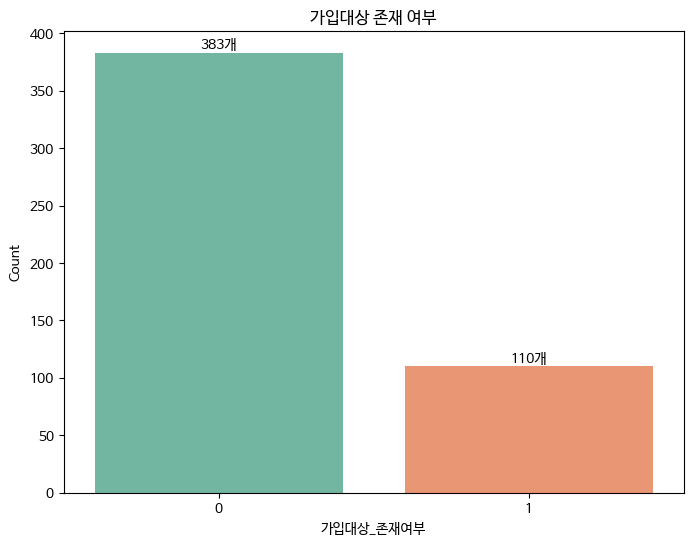

In [12]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='가입대상_존재여부', data=df_tmp, palette='Set2')

# Add annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')


plt.title('가입대상 존재 여부')
plt.xlabel('가입대상_존재여부')
plt.ylabel('Count')
plt.show()

- 가입대상에서 나이 추출
    - 가입대상 조건에서 나이관련 조건이 있을 경우 추출한다.

In [13]:
range_list = ['미만','이하','이상','초과']
p =re.compile('[0-9]+세')
p2 = re.compile('[0-9]+~[0-9]+세')
p3 = re.compile('[0-9]+~[0-9]+대')

In [14]:
age_list = []
for i in range(len(df_tmp)):
    text_ori = df_tmp.loc[i,'가입대상_최종']
    text = text_ori.replace(" ","")

    if p3.search(text):
        s = p3.search(text).span()
        age_list.append(text[s[0]:s[1]])
    elif p2.search(text):
        s = p2.search(text).span()
        age_list.append(text[s[0]:s[1]])
    elif p.search(text):
        s = p.search(text).span()
        for r in range_list:
            range_w = ""
            if text[s[1]:s[1]+2] == r:
                range_w = text[s[1]:s[1]+2]
                break
        age_list.append(text[s[0]:s[1]] +" " +  range_w)
    else:
        age_list.append("나이제한없음")

print(age_list)

['나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '64세 이상', '64세 이상', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '19세 이상', '19세 이상', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음', '나이제한없음',

In [15]:
df_tmp['나이제한'] = age_list

In [16]:
# 수치형으로 군집분석에 이용하기 위한 라벨링
## 0 : 나이제한이 존재하지 않음
## 1 : 나이제한이 존재함


def label_based_on_target(row):
    if row['나이제한'] == '나이제한없음':
        return 0
    else:
        return 1

df_tmp['나이제한_존재여부'] = df_tmp.apply(label_based_on_target, axis=1)

- 나이 제한 존재여부 확인
    - 예금 6개월의 경우 4.5% 정도 나이제한이 존재한다.

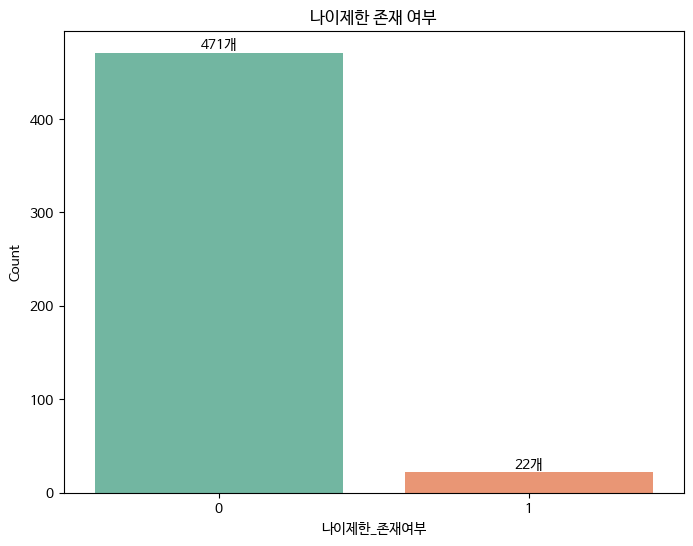

In [17]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='나이제한_존재여부', data=df_tmp, palette='Set2')

# Add annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('나이제한 존재 여부')
plt.xlabel('나이제한_존재여부')
plt.ylabel('Count')
plt.show()

### 3.3 우대조건 전처리

- 우대조건 칼럼 전처리
    - 없음이 다양한 형태로 입력되어 있음
    - 우대조건이 없을 경우 모두 '없음'으로 통일해 우대조건 존재여부를 확인한다.

In [18]:
no_prime = ['없음', '해당없음', '-', '- 없음','해당사항없음', '- 없음', '우대조건 없음', '우대사항없음', '없음.', '* 해당사항없음', '-없음', '해당무']
df_tmp['우대조건'] = df_tmp['우대조건'].apply(lambda x: '없음' if x in no_prime else x)

In [19]:
# 수치형으로 군집분석에 이용하기 위한 라벨링
## 0 : 우대조건이 존재하지 않음
## 1 : 우대조건이 존재함

def label_based_on_target(row):
    if row['우대조건'] == '없음':
        return 0
    else:
        return 1

df_tmp['우대조건_존재여부'] = df_tmp.apply(label_based_on_target, axis=1)

- 우대조건 존재 여부 확인
    - 예금 6개월의 경우 우대조건이 존재하는 상품은 18% 정도이다.
    - 예금 상품은 전반적으로 우대조건이 존재하는 상품이 많지 않다.

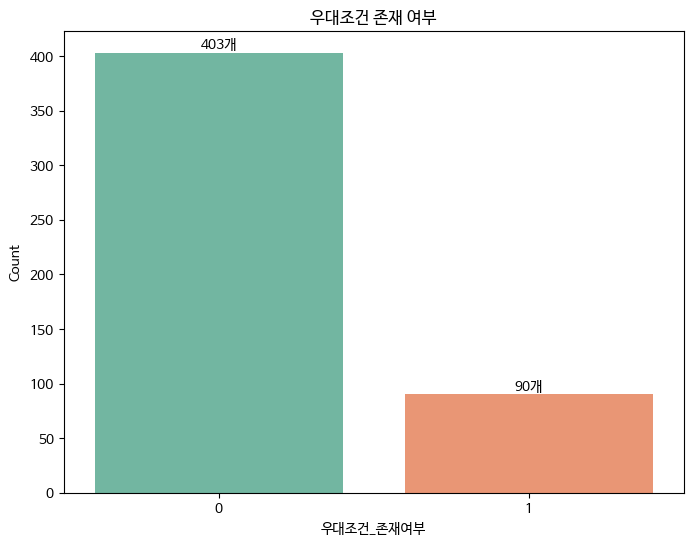

In [20]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='우대조건_존재여부', data=df_tmp, palette='Set2')

# Add annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('우대조건 존재 여부')
plt.xlabel('우대조건_존재여부')
plt.ylabel('Count')
plt.show()

- 가입방식에 따른 우대조건 존재여부

In [21]:
def create_method(x):
    method_list_e = ['인터넷','모바일','스마트','비대면']
    for m in method_list_e :
        if m in x :
            return '비대면'
    method_list = ['창구','영업점']
    for m in method_list:
        if m in x :
            return "대면"
    return "우대없음"

In [22]:
df_tmp['가입방식우대_존재여부'] = df_tmp['우대조건'].apply(lambda x :create_method(x) )

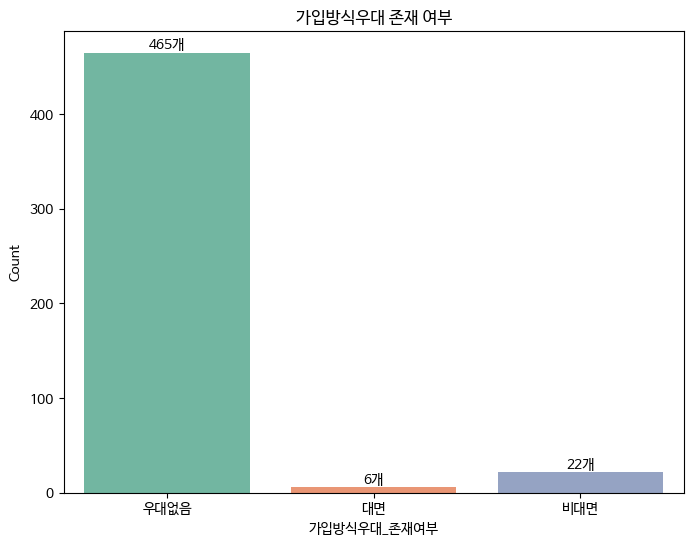

In [23]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='가입방식우대_존재여부', data=df_tmp, palette='Set2')

# Add annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('가입방식우대 존재 여부')
plt.xlabel('가입방식우대_존재여부')
plt.ylabel('Count')
plt.show()

- 자동이체에 따른 우대사항 존재여부

In [24]:
# 이체 우대
def transfer(x):
    if "이체" not in x:
        return "우대없음"
    if "자동" in x:
        return "자동이체우대"
    if "급여" in x  or "소득" in x :
        return "급여이체우대"

In [25]:
df_tmp['이체우대_존재여부'] = df_tmp['우대조건'].apply(lambda x :transfer(x) )

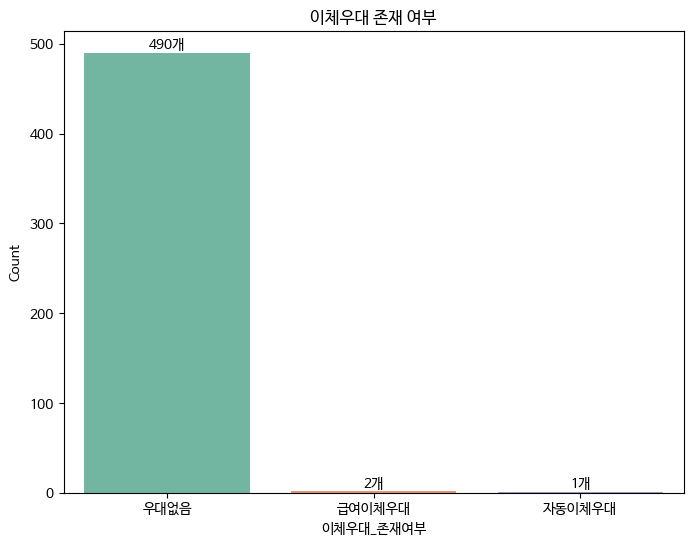

In [26]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='이체우대_존재여부', data=df_tmp, palette='Set2')

# Add annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('이체우대 존재 여부')
plt.xlabel('이체우대_존재여부')
plt.ylabel('Count')
plt.show()

- 만기 이후 우대사항 존재 여부

In [27]:
# 만기 우대
def maturity(x):
    if "만기" not in x:
        return "우대없음"
    if "만기" in x:
        return "만기시우대"

In [28]:
df_tmp['만기우대_존재여부'] = df_tmp['우대조건'].apply(lambda x :maturity(x) )

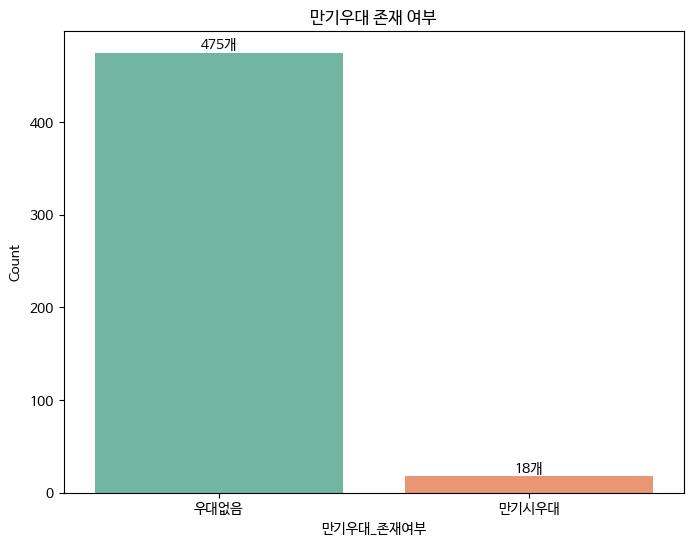

In [29]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='만기우대_존재여부', data=df_tmp, palette='Set2')

# Add annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('만기우대 존재 여부')
plt.xlabel('만기우대_존재여부')
plt.ylabel('Count')
plt.show()

- 실적에 따른 우대사항 존재 여부

In [30]:
# 실적 우대
def card(x):
    if "실적" not in x and "카드" not in x:
        return "우대없음"
    if "카드" in x:
        return "카드실적우대"
    if "실적" in x:
        return "카드 외 실적우대"

df_tmp['실적우대_존재여부'] = df_tmp['우대조건'].apply(lambda x :card(x) )

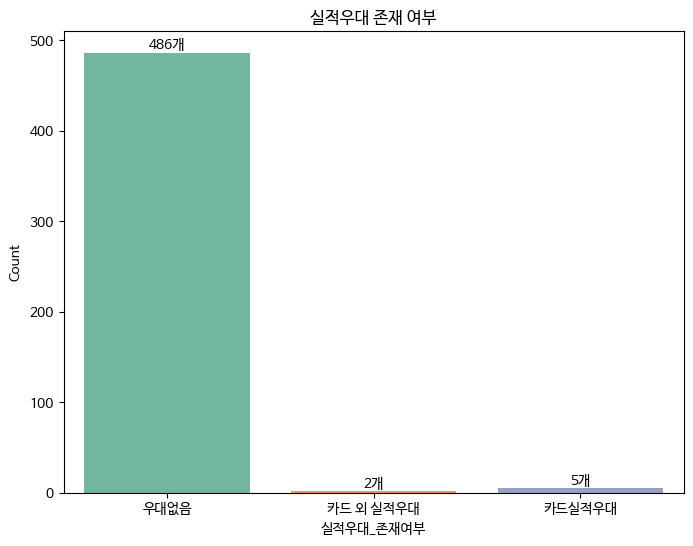

In [31]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='실적우대_존재여부', data=df_tmp, palette='Set2')

# Add annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('실적우대 존재 여부')
plt.xlabel('실적우대_존재여부')
plt.ylabel('Count')
plt.show()

- 기타우대

    - 마케팅 동의
    - 청약
    - 신규
    - 직장인

In [32]:
def etc(x):
    list_ = []
    if "동의" in x:
        list_.append("마켓팅동의우대")
    if "청약" in x:
        list_.append("청약가입우대")
    if ("신규" in x )or ("첫거래" in x) or ("최초" in x )or( "첫번째" in x):
        list_.append("최초고객우대")
    if "직장인" in x or "근로자" in x :
        list_.append("직장인우대")
    if "당행" in x or "당사" in x:
        list_.append("해당은행우대")
    if not list_:
        return "우대없음"
    else:
        return " ".join(list_)

In [33]:
df_tmp['기타우대_존재여부'] = df_tmp['우대조건'].apply(lambda x :etc(x) )

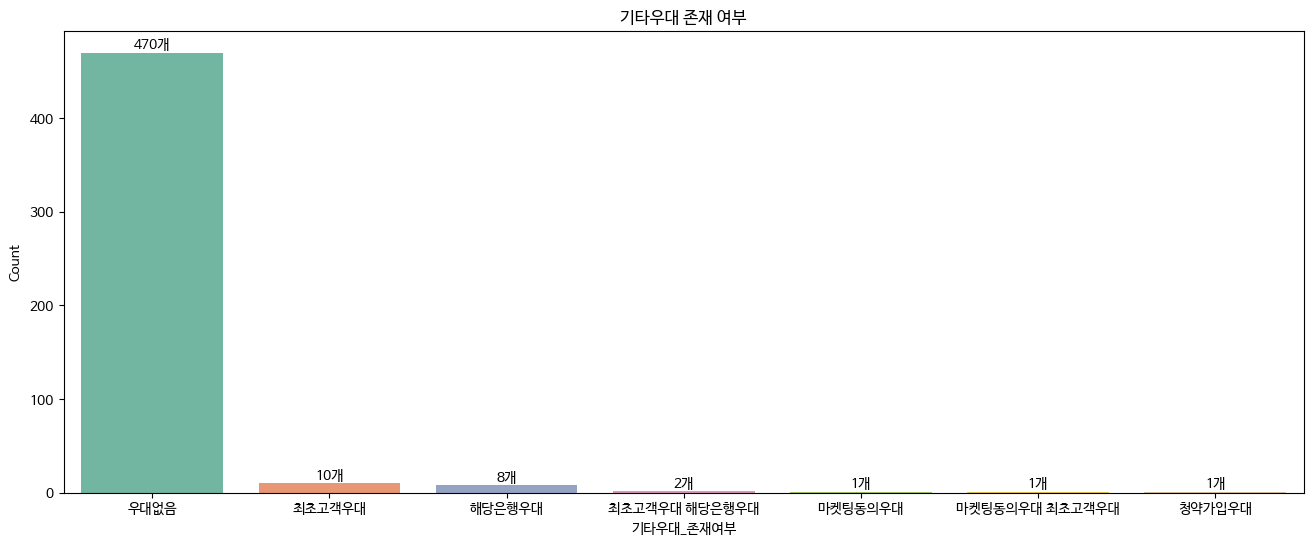

In [34]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(x='기타우대_존재여부', data=df_tmp, palette='Set2')

# Add annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('기타우대 존재 여부')
plt.xlabel('기타우대_존재여부')
plt.ylabel('Count')
plt.show()

### 3.4 % to float

- %문자열 수치형으로 변환

In [35]:
df_tmp['세전이자율'] = df_tmp['세전이자율'].str.rstrip('%').astype('float')
df_tmp['세후이자율'] = df_tmp['세후이자율'].str.rstrip('%').astype('float')
df_tmp['최고우대금리'] = df_tmp['최고우대금리'].str.rstrip('%').astype('float')

### 3.5 실질 이자율 추가
- 실질 이자율 : 만기 후 받게되는 이자의 현시점 기준 가치 산출
- 참고 : https://github.com/todhm/finda
- 23년 11월 기준 한국은행 기준금리는 3.5%로 실질이자율이 0 미만인 상품들이 다수 존재한다.

In [36]:
bir = 0.035 # 현재 기준금리 3.5% 반영

def month_df_real(interest,month):
    if not np.isnan(interest):
        a = 100 # 지급한 금액의 가치
        b = (interest) * (month/12.0) + 100  # 수익의 미래가치
        b = b / (1 + bir)**(month/12.0) # 만기후 수령액의 현재가치
        return ((b/a)**(12.0/month) - 1) * 100 # 1년 평균 이자율
    else:
        return 0

def month_df_complex_real(interest,month):
    if interest != np.nan:
        a =  100
        b =  100 * (1 + (interest * 0.01))** (month / 12.0)
        b = b / (1+ bir)**(month/12.0) # 만기후 수령액의 현재가치
        return ((b/a)**(12.0/month) - 1) * 100

    else:
        return 0

In [37]:
real_interest = []
interest_period = []

for i in range(len(df_tmp)):
    if df_tmp.loc[i, '이자계산방식'] == '단리':  # 상품의 금리방식이 단리인 경우
        real_interest.append(month_df_real(df_tmp.loc[i, '세전이자율'], 6))
        interest_period.append(6)

    elif df_tmp.loc[i, '이자계산방식'] == '복리':  # 상품의 금리방식이 복리인 경우
        real_interest.append(month_df_complex_real(df_tmp.loc[i, '세전이자율'], 6))
        interest_period.append(6)

print(real_interest)

[0.9661835748792091, 1.0150966183574806, 0.9661835748792091, 1.0150966183574806, 0.9163285024154311, 0.8695652173913215, 0.8212560386472889, 0.8669625603864528, 0.8274785024154685, 0.782608695652165, 0.8176086956521944, 0.7729468599033673, 0.8176086956521944, 0.7729468599033673, 0.8176086956521944, 0.8176086956521944, 0.7729468599033673, 0.7729468599033673, 0.7729468599033673, 0.8176086956521944, 0.8176086956521944, 0.7729468599033673, 0.7729468599033673, 0.8176086956521944, 0.7729468599033673, 0.8176086956521944, 0.8176086956521944, 0.7729468599033673, 0.7729468599033673, 0.8176086956521944, 0.7729468599033673, 0.7729468599033673, 0.7729468599033673, 0.8176086956521944, 0.7729468599033673, 0.8176086956521944, 0.7729468599033673, 0.8176086956521944, 0.7729468599033673, 0.7682669082125893, 0.7246376811594235, 0.7246376811594235, 0.7682669082125893, 0.6859903381642329, 0.7288021739130679, 0.7189371980676595, 0.6763285024154353, 0.7189371980676595, 0.6763285024154353, 0.7189371980676595, 

In [38]:
df_tmp['실질이자율'] = real_interest

### 3.6 가입방법 칼럼 전처리
- 전처리 방식
    - '인터넷,스마트폰', -> 인터넷스마트폰전용
    - '영업점', -> 영업점방문
    - '스마트폰', -> 인터넷스마트폰전용
    - '인터넷', -> 인터넷스마트폰전용
    - '영업점,인터넷', -> 인터넷스마트폰영업점
    - '인터넷,스마트폰,전화(텔레뱅킹)', -> 인터넷스마트폰텔레뱅킹
    - '영업점,인터넷,스마트폰', -> 인터넷스마트폰영업점
    - '영업점,스마트폰', -> 인터넷스마트폰영업점
    - '영업점,인터넷,스마트폰,전화(텔레뱅킹)' -> 인터넷스마트폰텔레뱅킹



In [39]:
# join_method_mapping = {
#     '인터넷,스마트폰': '인터넷스마트폰전용',
#     '영업점': '영업점방문',
#     '스마트폰': '인터넷스마트폰전용',
#     '스마트폰,전화(텔레뱅킹)' : '인터넷스마트폰텔레뱅킹',
#     '인터넷': '인터넷스마트폰전용',
#     '영업점,인터넷': '인터넷스마트폰영업점',
#     '인터넷,스마트폰,전화(텔레뱅킹)': '인터넷스마트폰텔레뱅킹',
#     '영업점,인터넷,스마트폰': '인터넷스마트폰영업점',
#     '영업점,스마트폰': '인터넷스마트폰영업점',
#     '영업점,인터넷,스마트폰,전화(텔레뱅킹)': '인터넷스마트폰영업점텔레뱅킹',
#     '없음' : '기타',
#     '모집인' : '기타'
# }

# # 딕셔너리에 따라 값들 변경
# df_tmp['가입방법'] = df_tmp['가입방법'].map(join_method_mapping)

# print(df_tmp['가입방법'].value_counts())

- 텔레뱅킹이 포함된 상품은 많지 않으며, 현재 사용하지 않는 추세이다. 따라서 해당 부분은 이상치로 규정하고 대체한다.

In [40]:
join_method_mapping = {
    '인터넷,스마트폰': '인터넷스마트폰전용',
    '영업점': '영업점방문',
    '스마트폰': '인터넷스마트폰전용',
    '스마트폰,전화(텔레뱅킹)' : '인터넷스마트폰전용',
    '인터넷': '인터넷스마트폰전용',
    '영업점,인터넷': '인터넷스마트폰영업점',
    '인터넷,스마트폰,전화(텔레뱅킹)': '인터넷스마트폰전용',
    '영업점,인터넷,스마트폰': '인터넷스마트폰영업점',
    '영업점,스마트폰': '인터넷스마트폰영업점',
    '영업점,인터넷,스마트폰,전화(텔레뱅킹)': '인터넷스마트폰영업점',
    '없음' : '기타',
    '모집인' : '기타'
}

# 딕셔너리에 따라 값들 변경
df_tmp['가입방법'] = df_tmp['가입방법'].map(join_method_mapping)

print(df_tmp['가입방법'].value_counts())

인터넷스마트폰전용     284
영업점방문         180
인터넷스마트폰영업점     29
Name: 가입방법, dtype: int64


## 3.7 은행별 평가 등급 추가

In [41]:
# bank_info_df 은행명 변경
mapping_dict = {
    'OSB저축은행': '오에스비저축은행',
    'JT친애저축은행': '제이티친애저축은행',
    'OK저축은행': '오케이저축은행',
    'MS저축은행': '엠에스상호저축은행',
    'DH저축은행': '디에이치저축은행',
    'JT저축은행': '제이티저축은행',
    'BNK저축은행': '비엔케이저축은행',
    '푸른저축은행': '푸른상호저축은행',
    'SBI저축은행': '에스비아이저축은행',
    '유니온저축은행': '유니온상호저축은행',
    'IBK저축은행': '아이비케이저축은행',
    '세람저축은행': '세람상호저축은행',
    'KB저축은행': '케이비저축은행',
    '대원저축은행': '대원상호저축은행'
}

tmp = df_tmp['금융회사'].map(mapping_dict).fillna(df_tmp['금융회사'])
df_tmp['금융회사'] = tmp

In [42]:
bank_info_df.head()

,Unnamed: 0,구분,유형,BIS비율_등급,유동성비율_등급,총자산_등급,안정성,여신비율_등급,대손충당금_등급,자기자본_등급,건전성,ROA_등급,당기순이익_등급,수익성,총합계,등급
0,0,주식회사 카카오뱅크,은행,107,116,83,52.0,129,100,87,28.85,79,81,16.0,96.85,1
1,1,남양저축은행,저축은행,109,90,39,45.6,114,108,49,20.90,145,75,22.0,88.50,1
2,2,국민은행,은행,88,24,94,38.2,136,104,93,30.60,73,93,16.6,85.40,1
3,3,한국씨티은행,은행,103,38,81,42.8,122,102,86,28.40,56,84,14.0,85.20,1
4,4,하나은행,은행,86,26,93,37.7,138,103,91,30.25,78,92,17.0,84.95,1


In [43]:
bank_info_df = bank_info_df[['구분','등급']]
bank_info_df.rename(columns = {'구분' : '금융회사'}, inplace = True)

In [44]:
df_tmp.merge(bank_info_df, how = 'left', on = '금융회사')['등급'].isnull().sum()

0

In [45]:
df_tmp = df_tmp.merge(bank_info_df, how = 'left', on = '금융회사')

# [4] 수치형 전처리

- 최고_기본_diff :  최고우대금리 - 세전이자율

In [46]:
df_tmp['최고_기본_diff'] = df_tmp['최고우대금리'] - df_tmp['세전이자율']

In [47]:
df_tmp['최고_기본_diff'].unique()

array([0.  , 0.2 , 0.1 , 0.35, 0.1 , 0.4 , 0.5 , 0.3 , 0.3 , 0.9 , 1.2 ,
       0.65, 0.25, 1.3 , 1.1 , 0.45, 1.75, 3.05])

In [48]:
# 수치형으로 군집분석에 이용하기 위한 라벨링
## 0 : 나이제한이 존재하지 않음
## 1 : 나이제한이 존재함
## 2 : 우대금리와 기본금리의 차이가 0.5% 초과


def label_based_on_target(row):
    if row['최고_기본_diff'] == 0:
        return 0
    elif row['최고_기본_diff'] <= 0.5:
        return 1
    else:
        return 2

df_tmp['최고기본금리차이'] = df_tmp.apply(label_based_on_target, axis=1)

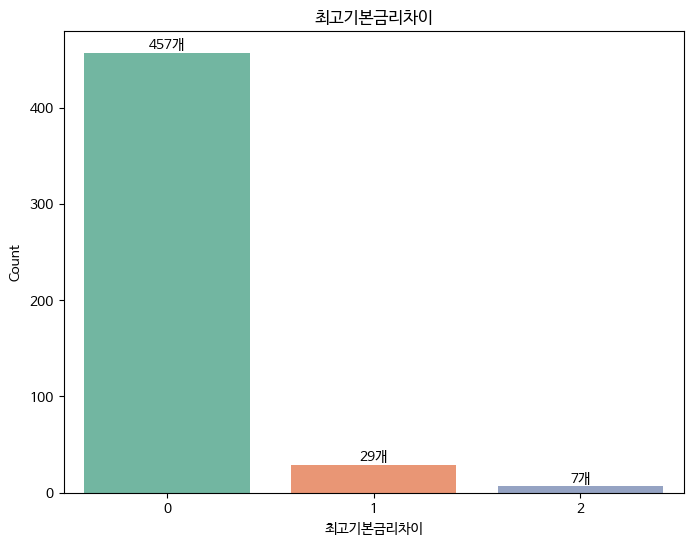

In [49]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='최고기본금리차이', data=df_tmp, palette='Set2')

# Add annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('최고기본금리차이')
plt.xlabel('최고기본금리차이')
plt.ylabel('Count')
plt.show()

- 최고_기준_diff : 최고우대금리 - 현재금리(3.5)

In [50]:
df_tmp['최고_기준_diff'] = df_tmp['최고우대금리'] - 3.5

- 은행 구분

In [51]:
bank_list = list(set(list(df_tmp['금융회사'].unique())))

# 저축은행(jb)와 일반은행(gb)로 분할한다.
jb = []
gb = []
ob = ['주식회사 카카오뱅크',  '토스뱅크 주식회사', '주식회사 케이뱅크']

for bank in bank_list:
    if '저축' in bank:
        jb.append(bank)
    else:
        gb.append(bank)

gb_not_ob = [bank for bank in gb if bank not in ob]

# 결과 출력
print("저축은행 리스트:", jb)
print("일반은행 리스트:", gb)
print("온라인은행 리스트:", ob)
print("온라인은행 제외 일반은행:", gb_not_ob)

저축은행 리스트: ['대원상호저축은행', '우리금융저축은행', '페퍼저축은행', '아이비케이저축은행', 'CK저축은행', '고려저축은행', '웰컴저축은행', '비엔케이저축은행', '청주저축은행', '흥국저축은행', '삼호저축은행', '영진저축은행', '유안타저축은행', '남양저축은행', '민국저축은행', '안국저축은행', '오투저축은행', '융창저축은행', '오케이저축은행', '라온저축은행', '대명상호저축은행', '다올저축은행', '유니온상호저축은행', '아산저축은행', '조은저축은행', '바로저축은행', '대백저축은행', '인성저축은행', '스카이저축은행', '제이티친애저축은행', '한화저축은행', '안양저축은행', '솔브레인저축은행', '케이비저축은행', '상상인저축은행', '엠에스상호저축은행', '푸른상호저축은행', '참저축은행', '평택상호저축은행', '우리저축은행', '대한저축은행', '한성저축은행', '더케이저축은행', '스마트저축은행', '조흥저축은행', '동양저축은행', '제이티저축은행', '상상인플러스저축은행', '스타저축은행', '엔에이치저축은행', '진주저축은행', '머스트삼일저축은행', '세람상호저축은행', '키움예스저축은행', '에스앤티저축은행', '드림저축은행', '모아저축은행', 'HB저축은행', '부림저축은행', '오성저축은행', '국제저축은행', '에스비아이저축은행', '인천저축은행', '예가람저축은행', '키움저축은행', '디에이치저축은행', '오에스비저축은행', '하나저축은행', '동원제일저축은행', '한국투자저축은행', '더블저축은행', '삼정저축은행', '신한저축은행', '대신저축은행', '애큐온저축은행', '대아상호저축은행', '금화저축은행', '센트럴저축은행', '디비저축은행']
일반은행 리스트: ['중소기업은행', '한국산업은행', '농협은행주식회사', '주식회사 카카오뱅크', '광주은행', '주식회사 케이뱅크', '전북은행', '경남은행', '국민은행', '대구은행', '부산은행', '우리은행', '한국스탠다드차타

In [52]:
def find_bank_type(df) :
    return df['금융회사'].apply(lambda x: '저축은행' if x in jb else ('온라인은행' if x in ob else ('일반은행' if x in gb_not_ob else None)))

In [53]:
df_tmp['금융회사_종류'] =  find_bank_type(df_tmp)

In [54]:
df_tmp.columns

Index(['금융회사', '상품명', '세전이자율', '세후이자율', '최고우대금리', '이자계산방식', '우대조건', '가입방법',
       '만기후 이자율', '기타유의사항', '가입대상_최종', '가입대상_존재여부', '나이제한', '나이제한_존재여부',
       '우대조건_존재여부', '가입방식우대_존재여부', '이체우대_존재여부', '만기우대_존재여부', '실적우대_존재여부',
       '기타우대_존재여부', '실질이자율', '등급', '최고_기본_diff', '최고기본금리차이', '최고_기준_diff',
       '금융회사_종류'],
      dtype='object')

# [5] 수치형칼럼으로 군집분석 실시



## 5.1 전처리

In [95]:
df_num_tmp = df_tmp[['세전이자율','최고우대금리', '실질이자율', '최고_기본_diff','이자계산방식', '가입방법', '금융회사_종류']]

In [96]:
df_num_tmp

,세전이자율,최고우대금리,실질이자율,최고_기본_diff,이자계산방식,가입방법,금융회사_종류
0,4.50,4.5,0.966184,0.00,복리,인터넷스마트폰전용,저축은행
1,4.50,4.5,1.015097,0.00,단리,인터넷스마트폰전용,저축은행
2,4.50,4.5,0.966184,0.00,복리,영업점방문,저축은행
3,4.50,4.5,1.015097,0.00,단리,영업점방문,저축은행
4,4.40,4.4,0.916329,0.00,단리,영업점방문,저축은행
...,...,...,...,...,...,...,...
488,1.50,1.5,-1.932367,0.00,복리,인터넷스마트폰전용,저축은행
489,1.40,1.4,-2.024251,0.00,단리,영업점방문,저축은행
490,1.40,1.4,-2.028986,0.00,복리,영업점방문,저축은행
491,1.00,1.0,-2.413043,0.00,단리,영업점방문,저축은행


- 라벨인코딩

In [97]:
label_cols = ['이자계산방식', '금융회사_종류', '가입방법']
label_mapping = {}

label_encoder = LabelEncoder()
for col in label_cols:
    df_num_tmp[col] = label_encoder.fit_transform(df_num_tmp[col])
    # 변환 전, 후의 매핑 정보 저장
    label_mapping[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

In [98]:
# 변환된 값 확인
print("Label Encoding Mapping:")
for col, mapping in label_mapping.items():
    print(f"{col} 변환 전: 후 -> {mapping}")

Label Encoding Mapping:
이자계산방식 변환 전: 후 -> {'단리': 0, '복리': 1}
금융회사_종류 변환 전: 후 -> {'온라인은행': 0, '일반은행': 1, '저축은행': 2}
가입방법 변환 전: 후 -> {'영업점방문': 0, '인터넷스마트폰영업점': 1, '인터넷스마트폰전용': 2}


- 스케일링 실시

In [99]:
columns_to_scale = ['세전이자율', '최고우대금리', '실질이자율']

# Min-Max Scaling을 위한 객체 생성
scaler = MinMaxScaler()

# 선택한 칼럼에 Min-Max Scaling 적용
df_num_tmp[columns_to_scale] = scaler.fit_transform(df_num_tmp[columns_to_scale])

df_num_tmp

,세전이자율,최고우대금리,실질이자율,최고_기본_diff,이자계산방식,가입방법,금융회사_종류
0,1.000000,1.000000,0.985931,0.00,1,2,2
1,1.000000,1.000000,1.000000,0.00,0,2,2
2,1.000000,1.000000,0.985931,0.00,1,0,2
3,1.000000,1.000000,1.000000,0.00,0,0,2
4,0.971831,0.971429,0.971591,0.00,0,0,2
...,...,...,...,...,...,...,...
488,0.154930,0.142857,0.152220,0.00,1,2,2
489,0.126761,0.114286,0.125791,0.00,0,0,2
490,0.126761,0.114286,0.124430,0.00,1,0,2
491,0.014085,0.000000,0.013963,0.00,0,0,2


In [100]:
df_num_tmp.info()
# 수치형 데이터로 준비 완료

<class 'pandas.core.frame.DataFrame'>
Int64Index: 493 entries, 0 to 492
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   세전이자율       493 non-null    float64
 1   최고우대금리      493 non-null    float64
 2   실질이자율       493 non-null    float64
 3   최고_기본_diff  493 non-null    float64
 4   이자계산방식      493 non-null    int64  
 5   가입방법        493 non-null    int64  
 6   금융회사_종류     493 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 30.8 KB


## 5.2 군집분석 (K-means)

#### 데이터 확인

In [101]:
df_num_tmp_km = df_num_tmp.copy()

#### Elbow 그림으로 최적 군집 갯수 확인, 실루엣 score 확인

In [102]:
df_num_tmp_km

,세전이자율,최고우대금리,실질이자율,최고_기본_diff,이자계산방식,가입방법,금융회사_종류
0,1.000000,1.000000,0.985931,0.00,1,2,2
1,1.000000,1.000000,1.000000,0.00,0,2,2
2,1.000000,1.000000,0.985931,0.00,1,0,2
3,1.000000,1.000000,1.000000,0.00,0,0,2
4,0.971831,0.971429,0.971591,0.00,0,0,2
...,...,...,...,...,...,...,...
488,0.154930,0.142857,0.152220,0.00,1,2,2
489,0.126761,0.114286,0.125791,0.00,0,0,2
490,0.126761,0.114286,0.124430,0.00,1,0,2
491,0.014085,0.000000,0.013963,0.00,0,0,2


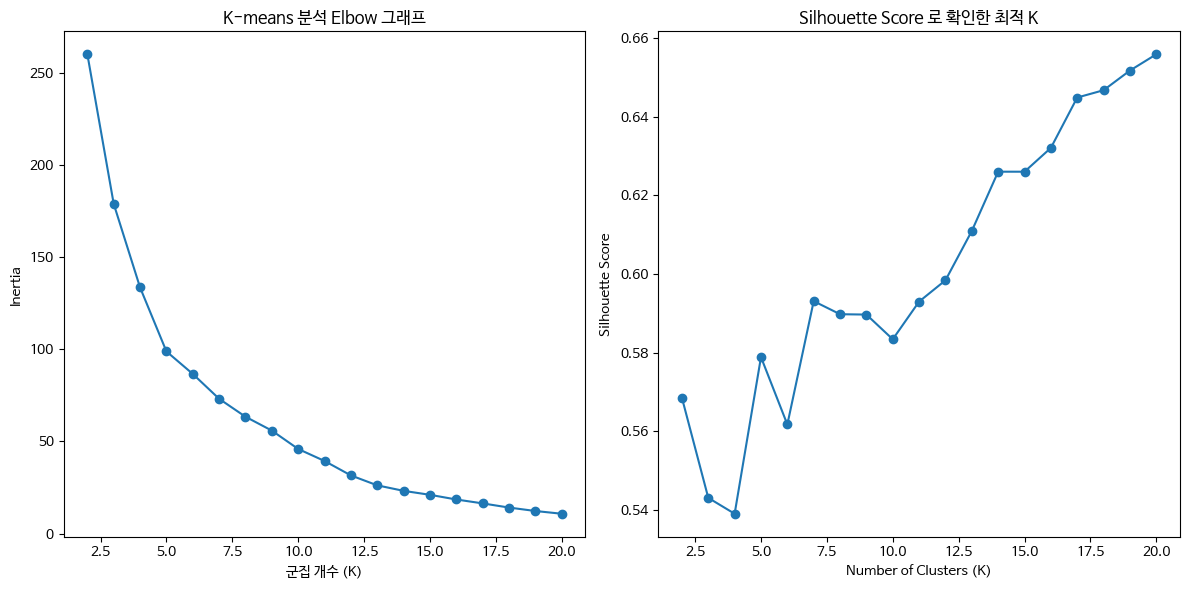

In [103]:
# Elbow Method로 최적 K 찾기
inertia = []
silhouette = []
max_k = 20  # 최대 K 값 설정
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=22, max_iter = 777)
    kmeans.fit(df_num_tmp_km)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(df_num_tmp_km, kmeans.labels_))

# Inertia 그래프 그리기 [Inertia : 각 군집별로 중심점에 얼마나 가깝게 모여있는가?]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_k + 1), inertia, marker='o')
plt.title('K-means 분석 Elbow 그래프')
plt.xlabel('군집 개수 (K)')
plt.ylabel('Inertia')

# Silhouette 그래프 그리기
plt.subplot(1, 2, 2)
plt.plot(range(2, max_k + 1), silhouette, marker='o')
plt.title('Silhouette Score 로 확인한 최적 K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

#### 최적 K로 군집분석

In [105]:
kmeans = KMeans(n_clusters = 13, random_state=22)
kmeans.fit(df_num_tmp_km)

# 클러스터 결과를 데이터프레임에 추가
df_num_tmp_km['cluster_num'] = kmeans.labels_

#### 군집 분포 확인

In [106]:
# 직관적인 비교를 위한 스케일링 inverse transform
df_num_tmp_km[columns_to_scale] = scaler.inverse_transform(df_num_tmp_km[columns_to_scale])

# 상품명, 금융회사명, 등급 다시 추가
df_num_tmp_km['상품명'] = df_tmp['상품명']
df_num_tmp_km['은행명'] = df_tmp['금융회사']
df_num_tmp_km['등급'] = df_tmp['등급']

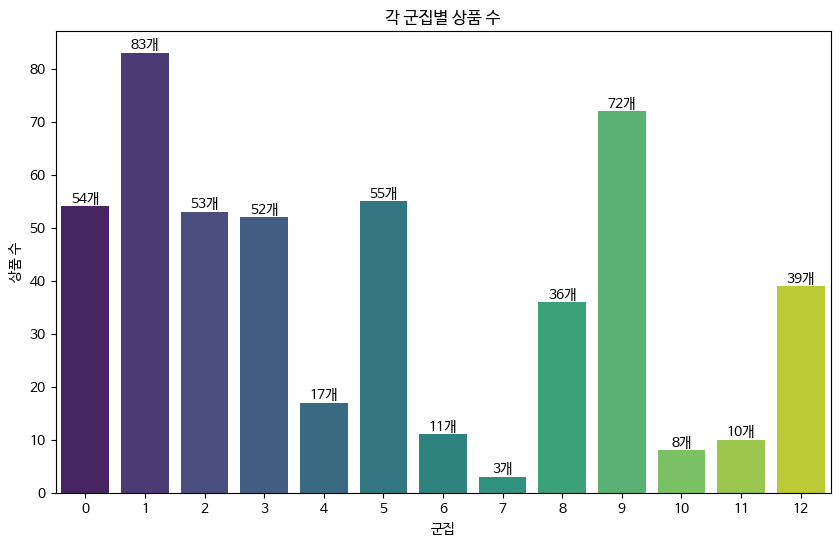

In [107]:
df_result_km = df_num_tmp_km.groupby(['cluster_num']).count()['상품명'].reset_index()

plt.figure(figsize=(10, 6))

ax = sns.barplot(x='cluster_num', y='상품명', data= df_result_km, palette='viridis')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('각 군집별 상품 수')
plt.xlabel('군집')
plt.ylabel('상품 수')
plt.show()

## 5.3 군집별 특징 파악

### 시각화 전처리

In [108]:
df_num_tmp_km.columns

Index(['세전이자율', '최고우대금리', '실질이자율', '최고_기본_diff', '이자계산방식', '가입방법', '금융회사_종류',
       'cluster_num', '상품명', '은행명', '등급'],
      dtype='object')

In [109]:
df_num_mean_result = df_num_tmp_km.groupby(['cluster_num']).mean()[['세전이자율', '최고우대금리', '실질이자율', '최고_기본_diff','이자계산방식','가입방법']].reset_index()

### 전체적인 평균 분포 확인

In [110]:
df_num_mean_result

,cluster_num,세전이자율,최고우대금리,실질이자율,최고_기본_diff,이자계산방식,가입방법
0,0,2.775741,2.775741,-0.680737,0.000000,0.0,2.0
1,1,3.887349,3.901807,0.374251,0.014458,1.0,2.0
2,2,3.917925,3.927358,0.441122,0.009434,0.0,0.0
3,3,3.970192,3.979808,0.454292,0.009615,1.0,0.0
4,4,3.598824,3.795882,0.127226,0.197059,0.0,2.0
5,5,2.657273,2.657273,-0.814229,0.000000,1.0,2.0
6,6,3.228182,3.264545,-0.262626,0.036364,1.0,1.0
7,7,2.000000,4.033333,-1.438200,2.033333,0.0,2.0
8,8,2.660556,2.666111,-0.793330,0.005556,0.0,0.0
9,9,3.927083,3.927083,0.450077,0.000000,0.0,2.0


- 군집별 평균을 비교하는 Barplot 함수 생성

In [111]:
def plot_cluster_comparison(df, feature):
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='cluster_num', y=feature, data=df, palette='Paired')

    for p in ax.patches:
         ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')

    plt.title(f'군집별 평균 {feature} 비교')

    plt.xlabel('군집')
    plt.ylabel(feature)

    plt.show()

### 세전이자율 분포 확인

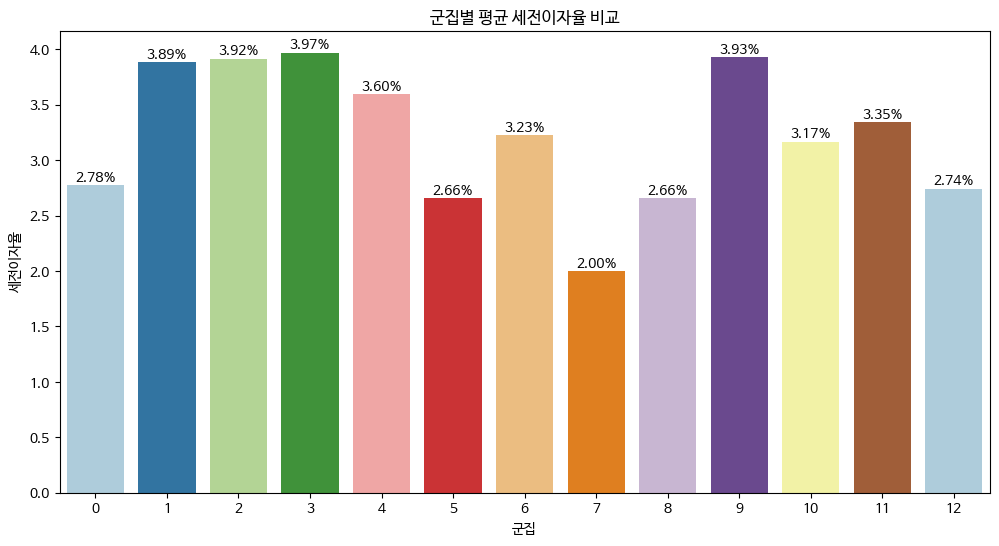

In [112]:
plot_cluster_comparison(df_num_mean_result, '세전이자율')

* 군집별 특징 분석 (세전 이자율)
<br/>
(+) 구분 기준 : (매우 높다, 높다, 보통, 낮다, 매우 낮다)
<br/>

- 0번 군집 :
- 1번 군집 :
- 2번 군집 :
- 3번 군집 :
- 4번 군집 :
- 5번 군집 :
- 6번 군집 :
- 7번 군집 :
- 8번 군집 :
- 9번 군집 :
- 10번 군집 :
- 11번 군집 :
- 12번 군집 :
- 13번 군집 :
- 14번 군집 :

### 최고우대금리 분포 확인

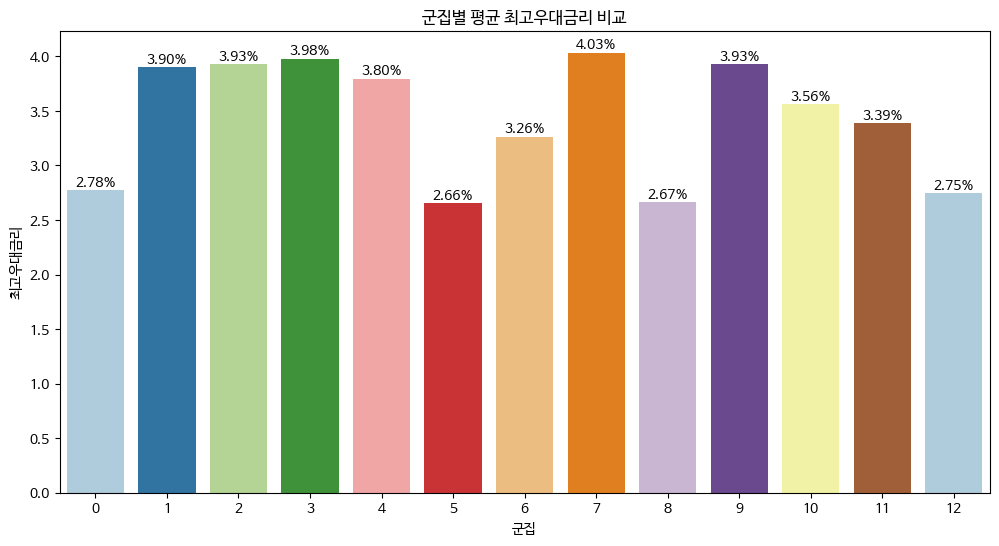

In [113]:
plot_cluster_comparison(df_num_mean_result, '최고우대금리')

* 군집별 특징 분석 (세전 이자율, 최고우대금리)
<br/>
(+) 구분 기준 : (매우 높다, 높다, 보통, 낮다, 매우 낮다)
<br/>


- 0번 군집 :
- 1번 군집 :
- 2번 군집 :
- 3번 군집 :
- 4번 군집 :
- 5번 군집 :
- 6번 군집 :
- 7번 군집 :
- 8번 군집 :
- 9번 군집 :
- 10번 군집 :
- 11번 군집 :
- 12번 군집 :
- 13번 군집 :
- 14번 군집 :

### 실질이자율 분포 확인

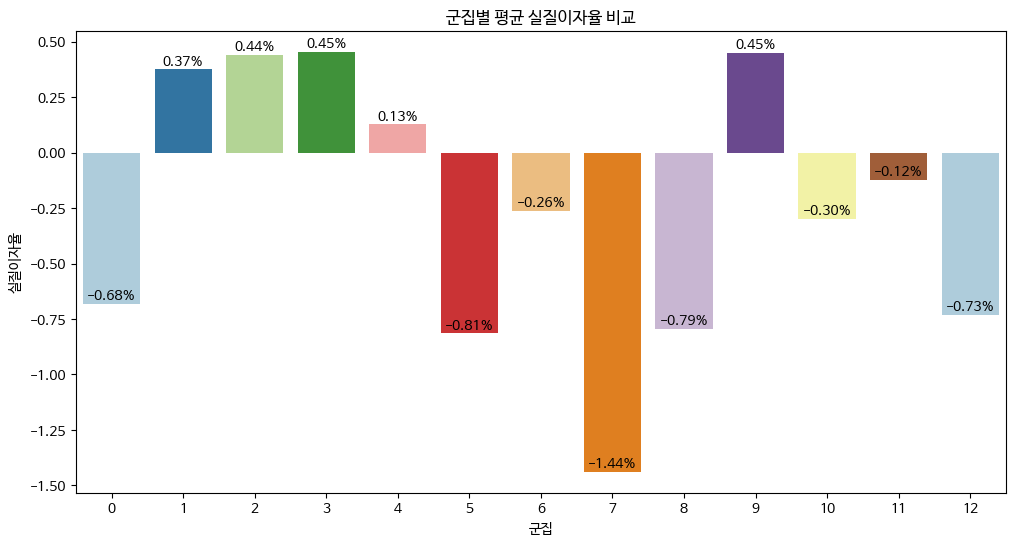

In [114]:
plot_cluster_comparison(df_num_mean_result, '실질이자율')

* 군집별 특징 분석 (세전 이자율, 최고우대금리)
<br/>
(+) 구분 기준 : (매우 높다, 높다, 보통, 낮다, 매우 낮다)
<br/>

- 기본 이자율로 계산했기 떄문에, 기본 이자율과 유사한 패턴이다.

### 최고우대금리 - 기본우대금리 차이 분포

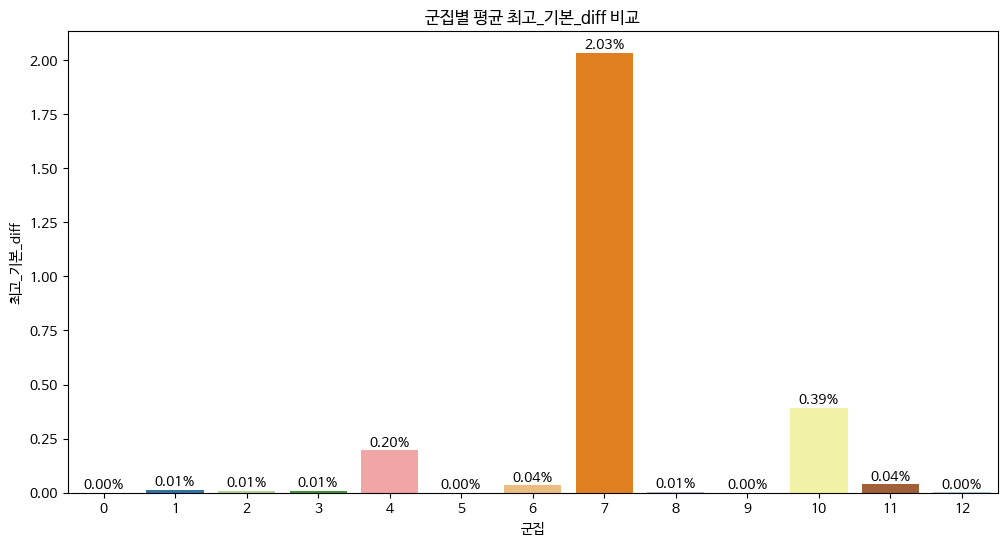

In [115]:
plot_cluster_comparison(df_num_mean_result, '최고_기본_diff')

- 8번 군집은 최고금리와 기본 금리의 편차가 가장 크다. (우대금리 존재)
- 그 다음은 3번 군집정도이다.

### 이자계산 방식 분포

- 0 : 단리
- 1 : 복리

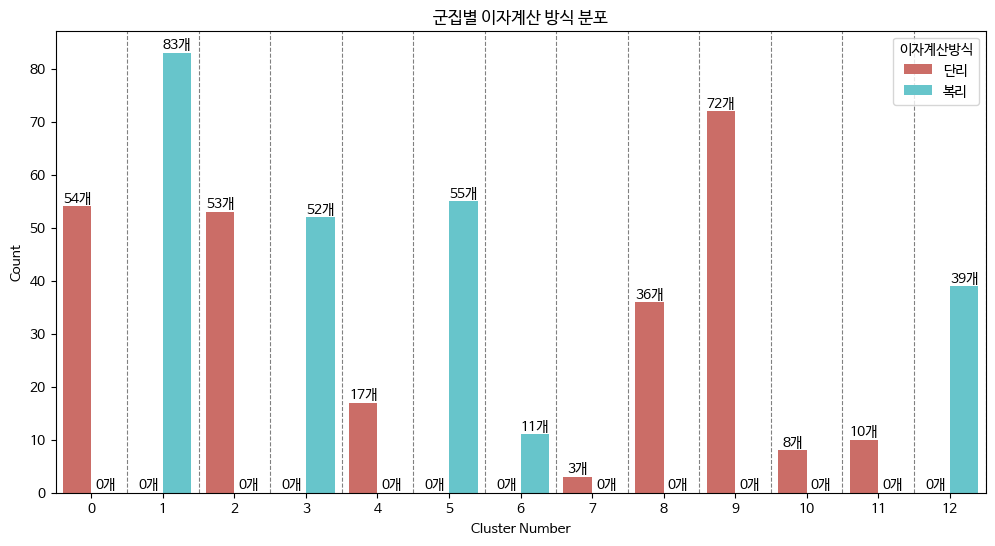

In [116]:
plt.figure(figsize=(12, 6))

ax = sns.countplot(x='cluster_num', hue='이자계산방식', data=df_num_tmp_km, palette='hls')

# annotations 추가
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.legend(title='이자계산방식', loc='upper right', labels=['단리', '복리'])

# 점선 추가
for i in range(len(ax.patches) // 2):
    plt.axvline(x=(1 * i + 0.5), color='gray', linestyle='--', linewidth=0.8)

plt.title('군집별 이자계산 방식 분포')
plt.xlabel('Cluster Number')
plt.ylabel('Count')
plt.show()

* 군집별 특징 분석
<br/>
(+) 구분 기준 : (매우 높다, 높다, 보통, 낮다, 매우 낮다)
<br/>


- 0번 군집 :
- 1번 군집 :
- 2번 군집 :
- 3번 군집 :
- 4번 군집 :
- 5번 군집 :
- 6번 군집 :
- 7번 군집 :
- 8번 군집 :
- 9번 군집 :
- 10번 군집 :
- 11번 군집 :
- 12번 군집 :
- 13번 군집 :
- 14번 군집 :

### 가입방법 분포 확인

- {'영업점방문': 0, '인터넷스마트폰영업점': 1, '인터넷스마트폰영업점텔레뱅킹': 2, '인터넷스마트폰전용': 3, '인터넷스마트폰텔레뱅킹': 4}

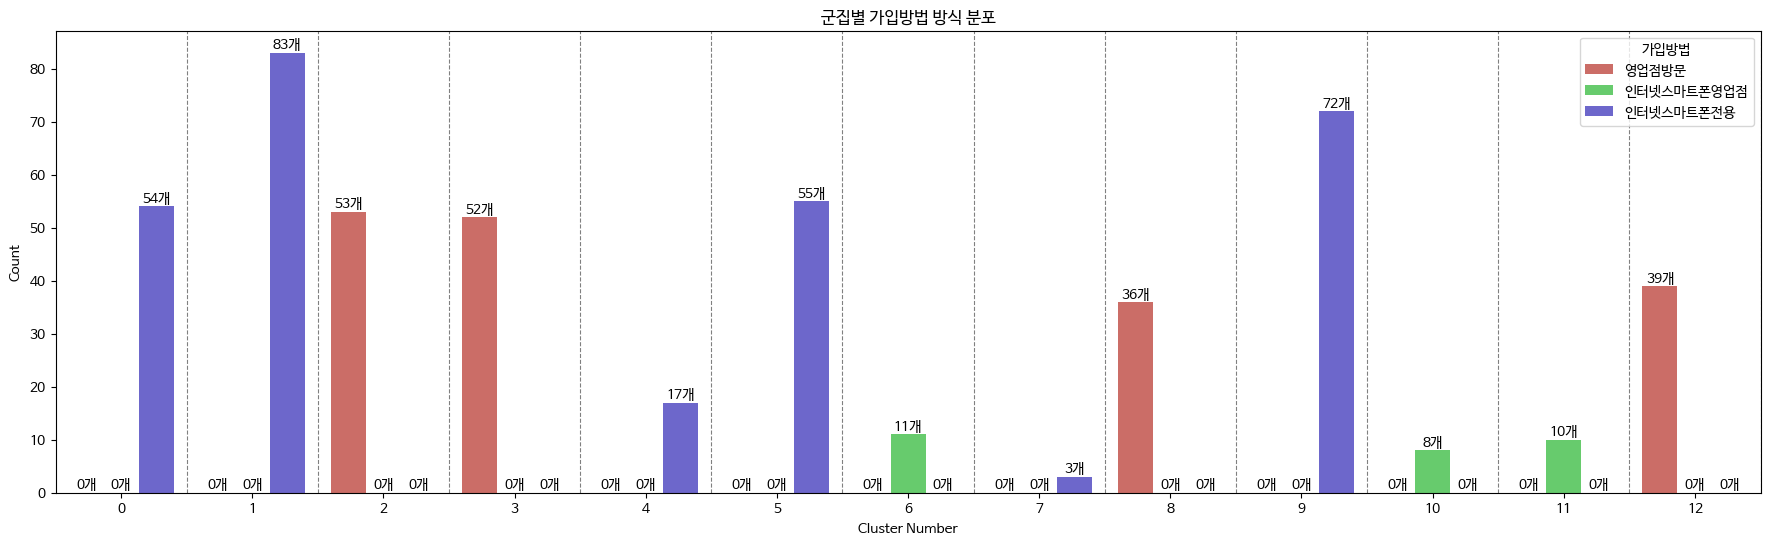

In [117]:
plt.figure(figsize=(22, 6))

ax = sns.countplot(x='cluster_num', hue='가입방법', data=df_num_tmp_km, palette='hls')

# annotations 추가
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.legend(title='가입방법', loc='upper right', labels=['영업점방문', '인터넷스마트폰영업점','인터넷스마트폰전용'])

# 점선 추가
for i in range(len(ax.patches) // 3):
    plt.axvline(x=(1 * i + 0.5), color='gray', linestyle='--', linewidth=0.8)

plt.title('군집별 가입방법 방식 분포')
plt.xlabel('Cluster Number')
plt.ylabel('Count')
plt.show()

#가입방법 변환 전: 후 -> {'영업점방문': 0, '인터넷스마트폰영업점': 1, '인터넷스마트폰전용': 2}


- 0번 군집 :
- 1번 군집 :
- 2번 군집 :
- 3번 군집 :
- 4번 군집 :
- 5번 군집 :
- 6번 군집 :
- 7번 군집 :
- 8번 군집 :
- 9번 군집 :
- 10번 군집 :
- 11번 군집 :
- 12번 군집 :
- 13번 군집 :
- 14번 군집 :

### 금융회사 종류 분포 확인

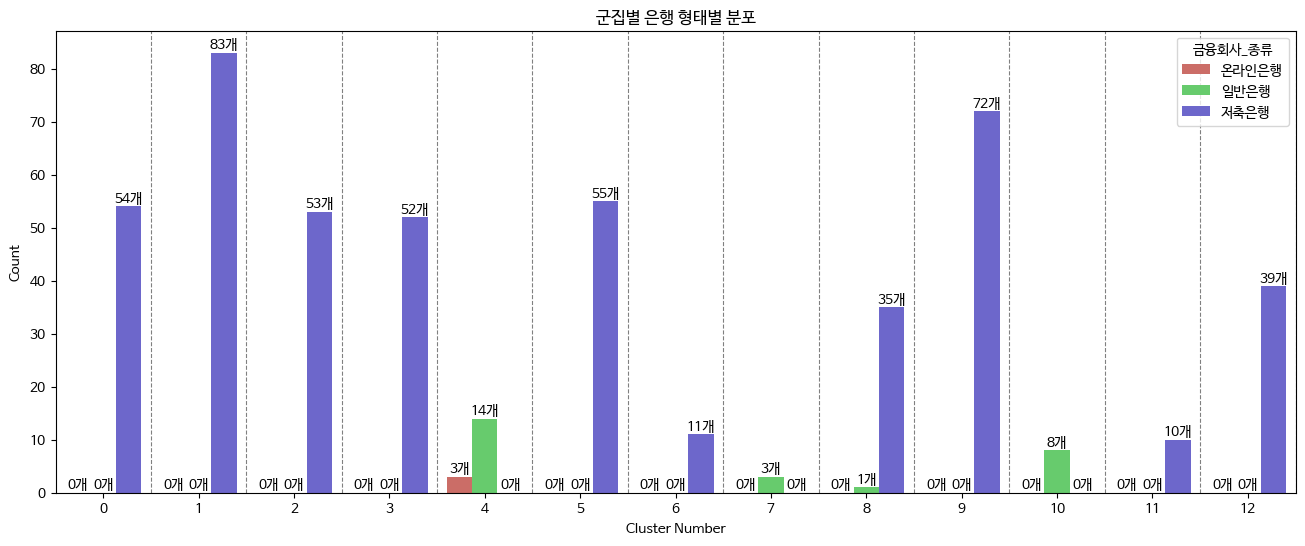

In [118]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(x='cluster_num', hue='금융회사_종류', data=df_num_tmp_km, palette='hls')

# annotations 추가
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.legend(title='금융회사_종류', loc='upper right', labels=['온라인은행', '일반은행','저축은행'])

# 점선 추가
for i in range(len(ax.patches) // 3):
    plt.axvline(x=(1 * i + 0.5), color='gray', linestyle='--', linewidth=0.8)

plt.title('군집별 은행 형태별 분포')
plt.xlabel('Cluster Number')
plt.ylabel('Count')
plt.show()

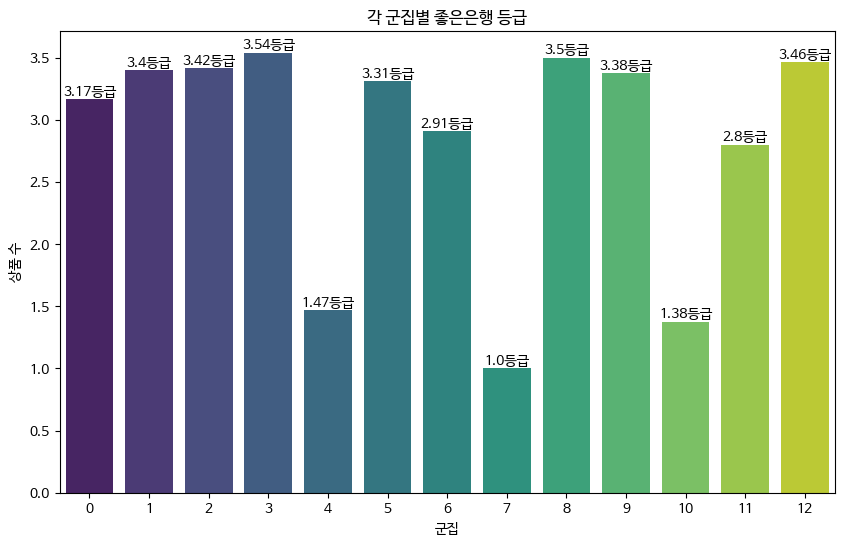

In [123]:
df_result_grade = df_num_tmp_km.groupby(['cluster_num']).mean()['등급'].reset_index()

plt.figure(figsize=(10, 6))

ax = sns.barplot(x='cluster_num', y='등급', data= df_result_grade, palette='viridis')

for p in ax.patches:
    ax.annotate(f'{round(p.get_height(), 2)}등급', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('각 군집별 좋은은행 등급')
plt.xlabel('군집')
plt.ylabel('상품 수')
plt.show()

## 5-4. 군집 결과 정리

* 군집별 특징 분석 (세전 이자율, 최고우대금리)
<br/>
(+) 구분 기준 : (매우 높다, 높다, 보통, 낮다, 매우 낮다)
<br/>


- 0번 군집 :
- 1번 군집 :
- 2번 군집 :
- 3번 군집 :
- 4번 군집 :
- 5번 군집 :
- 6번 군집 :
- 7번 군집 :
- 8번 군집 :
- 9번 군집 :
- 10번 군집 :
- 11번 군집 :
- 12번 군집 :
- 13번 군집 :
- 14번 군집 :

In [121]:
dp6_df['cluster_km'] = df_num_tmp_km['cluster_num']
dp6_df.head(2)

,금융회사,상품명,세전이자율,세후이자율,세후이자(예시),최고우대금리,가입대상,이자계산방식,기간,비교 공시일,담당부서 및 연락처,우대조건,가입대상.1,가입방법,만기후 이자율,기타유의사항,cluster_km
0,OSB저축은행,인터넷정기예금,4.50%,3.81%,"192,143",4.50%,제한없음,복리,6개월,2023-10-31,(예/적금) 고객지원팀 1644-0052 (공시) 전략분석팀 1644-0052,없음,제한없음,"인터넷,스마트폰",-만기후 1개월 이내 : 가입 시 약정금리와 만기 시 동일 상품의 금리 중 낮은 금...,-가입금액 : 10만원 이상\n-시장금리에 변동없는 최초 약정금리로 이자 수령,1
1,OSB저축은행,인터넷정기예금,4.50%,3.81%,"190,350",4.50%,제한없음,단리,6개월,2023-10-31,(예/적금) 고객지원팀 1644-0052 (공시) 전략분석팀 1644-0052,없음,제한없음,"인터넷,스마트폰",-만기후 1개월 이내 : 가입 시 약정금리와 만기 시 동일 상품의 금리 중 낮은 금...,-가입금액 : 10만원 이상\n-시장금리에 변동없는 최초 약정금리로 이자 수령,9


# [6] 결과 저장

- 덮어쓰기 주의!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [122]:
dp6_df.to_csv('/content/drive/MyDrive/ASAC_최종프로젝트/data/금융감독원데이터/상품데이터_크롤링/예금/deposit_6_with_cluster.csv', encoding = 'utf-8', index = False)